In [35]:
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from collections import namedtuple
from IPython.core.display import display, HTML
from IPython.display import Image

sys.path.append('/app/src')
warnings.filterwarnings("ignore")

In [36]:
result_root_dir = "/app/outputs/KITTI/errors/errors_for_eval/filter_comparison"
ekf_path = os.path.join(result_root_dir, "ekf")
ukf_path = os.path.join(result_root_dir, "ukf")
pf_path = os.path.join(result_root_dir, "pf")
enkf_path = os.path.join(result_root_dir, "enkf")
ckf_path = os.path.join(result_root_dir, "ckf")
setup_names = ["kinematics_w_gps", "kinematics_wo_gps", "velocity_w_gps", "velocity_wo_gps"]
ResultField = namedtuple('ResultField', ('seq', 'trans_error', 'rot_error', 'ATE', 'RPE_m', 'RPE_deg'))
metric_names = ["Trans. err. (%)", "Rot. err. (deg/100m)", "ATE (m)", "RPE (m)", "RPE (deg)"]
filter_names = ["EKF", "UKF", "PF", "EnKF", "CKF"]

In [37]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [38]:
def parse_result_file(filename: str) -> List[ResultField]:
    results = []

    with open(filename, "r") as f:
        result = ()
        for line in f:
            line = re.split(r': \t ', line)
            if len(line) == 2:
                line = line[-1]
                result = result + (float(line), )
            else:
                results.append(ResultField(*result))
                result = ()

    return results


In [39]:
def get_result_dict(filter_path):
    result_dict = dict()
    for root, dirs, files in os.walk(filter_path):
        path = root.split(os.sep)
        if len(path) == 9:
            setup = path[-1]
            filepath = "/".join(path)
        for file in files:
            if file == "result.txt":
                # print(f"{filepath}/{file}")
                result_filepath = os.path.join(filepath, file)
                result = parse_result_file(result_filepath)
                result_dict[setup] = result

    return result_dict

In [40]:
ekf_result = get_result_dict(ekf_path)
ukf_result = get_result_dict(ukf_path)
pf_result = get_result_dict(pf_path)
enkf_result = get_result_dict(enkf_path)
ckf_result = get_result_dict(ckf_path)

In [41]:
def get_metric_values(results, kf_result, setup, seq):
    results.append(
        [np.array([result.trans_error, result.rot_error, result.ATE, result.RPE_m, result.RPE_deg])\
             for result in kf_result[setup]\
             if result.seq == seq][0]
    )
    return results

def get_caption(setup: str):
    idx = setup_names.index(setup)
    if idx == 0:
        return "Estimation (Basics of Kinematics): IMU+VO+GPS"
    elif idx == 1:
        return "Estimation (Basics of Kinematics): IMU+VO"
    elif idx == 2:
        return "Estimation (Velocity Motion model): IMU+VO+GPS"
    else:
        return "Estimation (Velocity Motion model): IMU+VO"

seq_3 = dict()
seq_7 = dict()
seq_9 = dict()

sequences = [3., 7., 9.]
sequence_dict_list = [seq_3, seq_7, seq_9]

for seq, seq_dict in zip(sequences, sequence_dict_list):
    for setup in setup_names:
        seq_dict[setup] = []
        seq_dict[setup] = get_metric_values(seq_dict[setup], ekf_result, setup, seq)
        seq_dict[setup] = get_metric_values(seq_dict[setup], ukf_result, setup, seq)
        seq_dict[setup] = get_metric_values(seq_dict[setup], pf_result, setup, seq)
        seq_dict[setup] = get_metric_values(seq_dict[setup], enkf_result, setup, seq)
        seq_dict[setup] = get_metric_values(seq_dict[setup], ckf_result, setup, seq)

        
        seq_dict[setup] = pd.DataFrame(np.array(seq_dict[setup]).T, columns=filter_names, index=metric_names)


In [42]:
def show_dataframe(sequece_error_df, metric_indices, title):
    display(HTML(f"<h2 style='text-align: left; margin-left: 390px;'>{title}</h2>"))
    
    display(HTML(f"<h3 style='text-align: left; margin: 24px 0 12px 300px;'>Basics of kinematics state equation</h3>"))
    display_side_by_side(
        [sequece_error_df[setup_names[1]].iloc[metric_indices], sequece_error_df[setup_names[0]].iloc[metric_indices]],
        [get_caption(setup_names[1]), get_caption(setup_names[0])]
    )
    display(HTML(f"<h3 style='text-align: left; margin: 24px 0 12px 300px;'>Velocity motion model state equation</h3>"))
    display_side_by_side(
        [sequece_error_df[setup_names[3]].iloc[metric_indices], sequece_error_df[setup_names[2]].iloc[metric_indices]],
        [get_caption(setup_names[3]), get_caption(setup_names[2])]
    )
    display(HTML(f"<div style='margin-bottom: 40px;'></div>"))

# Filter comparison for each KITTI sequence

In [43]:
show_dataframe(seq_3, [2, 3, 4], "KITTI seq. 03")

,EKF,UKF,PF,EnKF,CKF
ATE (m),0.916000,0.997000,3.422000,1.026000,0.997000
RPE (m),0.153000,0.151000,2.484000,0.380000,0.152000
RPE (deg),1.992000,1.309000,2.919000,1.838000,1.300000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.101000,0.411000,1.391000,0.923000,0.411000
RPE (m),0.140000,0.141000,1.410000,0.254000,0.142000
RPE (deg),1.982000,1.298000,2.934000,1.872000,1.298000


,EKF,UKF,PF,EnKF,CKF
ATE (m),1.006000,1.130000,3.447000,1.160000,1.132000
RPE (m),0.169000,0.141000,2.687000,0.362000,0.141000
RPE (deg),1.989000,1.296000,3.107000,1.896000,1.297000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.117000,0.461000,1.141000,1.061000,0.461000
RPE (m),0.132000,0.138000,1.267000,0.255000,0.134000
RPE (deg),1.992000,1.298000,3.119000,1.892000,1.303000


<img src="../../../outputs/KITTI/images/trajectories/seq_03.png" style="height:350px">

In [44]:
show_dataframe(seq_7, [2, 3, 4], "KITTI seq. 07")

,EKF,UKF,PF,EnKF,CKF
ATE (m),8.686000,8.726000,9.999000,8.742000,8.726000
RPE (m),0.640000,0.062000,2.972000,0.366000,0.061000
RPE (deg),2.703000,0.492000,2.926000,1.138000,0.490000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.856000,3.635000,1.924000,2.408000,3.635000
RPE (m),0.669000,0.053000,1.853000,0.266000,0.054000
RPE (deg),2.413000,0.489000,2.482000,1.177000,0.490000


,EKF,UKF,PF,EnKF,CKF
ATE (m),8.669000,8.682000,10.066000,8.692000,8.681000
RPE (m),0.310000,0.035000,2.955000,0.366000,0.035000
RPE (deg),0.853000,0.431000,2.999000,1.082000,0.428000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.852000,3.622000,1.956000,4.096000,3.622000
RPE (m),0.058000,0.028000,1.809000,0.247000,0.028000
RPE (deg),0.796000,0.430000,2.574000,1.159000,0.429000


<img src="../../../outputs/KITTI/images/trajectories/seq_07.png" style="height:350px">

In [45]:
show_dataframe(seq_9, [2, 3, 4], "KITTI seq. 09")

,EKF,UKF,PF,EnKF,CKF
ATE (m),16.112000,16.195000,18.287000,16.068000,16.195000
RPE (m),0.621000,0.109000,3.311000,0.532000,0.108000
RPE (deg),3.851000,0.625000,2.671000,1.693000,0.625000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.961000,3.889000,2.381000,5.082000,3.889000
RPE (m),0.608000,0.100000,2.161000,0.384000,0.099000
RPE (deg),3.501000,0.626000,2.579000,1.641000,0.625000


,EKF,UKF,PF,EnKF,CKF
ATE (m),16.075000,16.191000,17.433000,16.155000,16.194000
RPE (m),0.452000,0.084000,3.365000,0.476000,0.084000
RPE (deg),1.238000,0.592000,2.747000,1.609000,0.593000
,EKF,UKF,PF,EnKF,CKF
ATE (m),0.953000,3.882000,2.203000,6.499000,3.882000
RPE (m),0.128000,0.060000,2.094000,0.321000,0.060000
RPE (deg),1.159000,0.591000,2.515000,1.582000,0.591000


<img src="../../../outputs/KITTI/images/trajectories/seq_09.png" style="height:350px">

In [58]:
def visualize_error_by_sequence(seq_dict, metric_indices, sequence_nr):
    fontsize = 14
    for metric_idx in metric_indices:
        df1 = pd.concat([
            seq_dict['kinematics_wo_gps'].iloc[metric_idx:metric_idx+1],
            seq_dict['velocity_wo_gps'].iloc[metric_idx:metric_idx+1]
        ], axis=0)\
            .reset_index()\
            .rename(index={0: "Basics of Kinematics", 1: "Velocity motion model"})[filter_names]
        
        df2 = pd.concat([
            seq_dict['kinematics_w_gps'].iloc[metric_idx:metric_idx+1],
            seq_dict['velocity_w_gps'].iloc[metric_idx:metric_idx+1]
        ], axis=0)\
            .reset_index()\
            .rename(index={0: "Basics of Kinematics", 1: "Velocity motion model"})[filter_names]

        metric_label = metric_names[metric_idx]
        
        vmin = 0
        vmax = 0
        for setup in setup_names:
            val = np.max(seq_dict[setup].iloc[metric_idx:metric_idx+1])
            vmax = val if vmax < val else vmax
        
        fig, axs = plt.subplots(2, 1, figsize=(12, 4))
        # Add an axis for the shared colorbar
        cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
            
        sns.heatmap(
            df1, 
            ax=axs[0], 
            vmin=vmin, 
            vmax=vmax,
            cmap="crest",
            annot=True,
            linewidths=1,
            fmt='.3g',
            cbar=False,
            xticklabels=False,
            yticklabels=df1.index,
            annot_kws={'size': fontsize}
        )
        sns.heatmap(
            df2, 
            ax=axs[1], 
            vmin=vmin, 
            vmax=vmax,
            cmap="crest",
            annot=True,
            linewidths=1,
            fmt='.3g',
            cbar=False,
            xticklabels=df2.columns,
            yticklabels=df2.index,
            annot_kws={'size': fontsize}
        )
        
        # Add a colorbar to the dedicated colorbar axis
        cmap = cm.get_cmap("crest")
        norm = colors.Normalize(vmin, vmax)
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
        
        fig.suptitle(f"Comparison for KITTI seq. {sequence_nr} by {metric_label}", size=20)
        
        # axs[0].yaxis.get_label().set_fontsize(8)
        # axs[1].yaxis.get_label().set_fontsize(8)
        axs[0].set_xlabel(None)
        axs[0].set_ylabel("w/ GPS", fontsize=16)
        axs[1].set_xlabel("Filter types", fontsize=16)
        axs[1].set_ylabel("w/o GPS", fontsize=16)
        
        # axs[0].set(xlabel=None, ylabel="Without GPS")
        # axs[1].set(xlabel="Filter types", ylabel="With GPS")
            
        axs[0].tick_params(left=True, bottom=False, labelsize=12) ## other options are right and top
        axs[1].tick_params(left=False, bottom=False, labelsize=12) ## other options are right and top
            
        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
        plt.show()

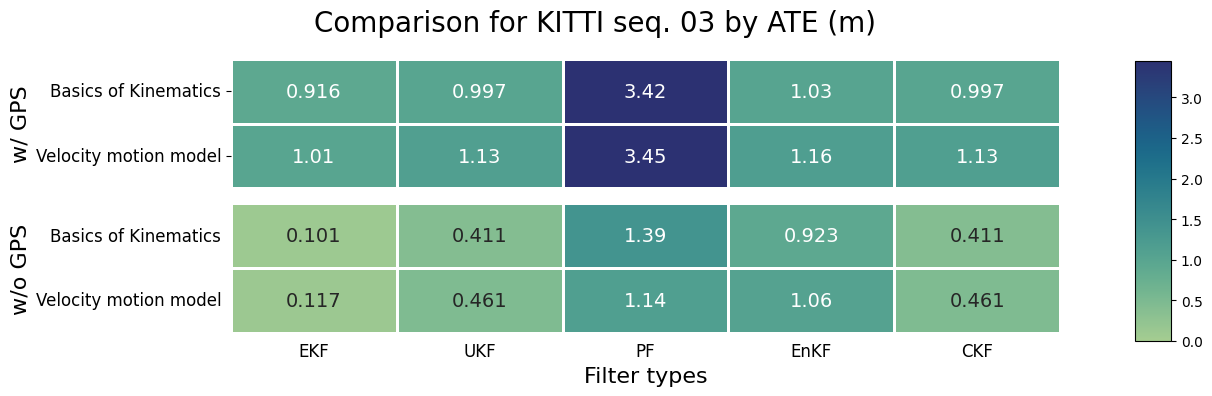

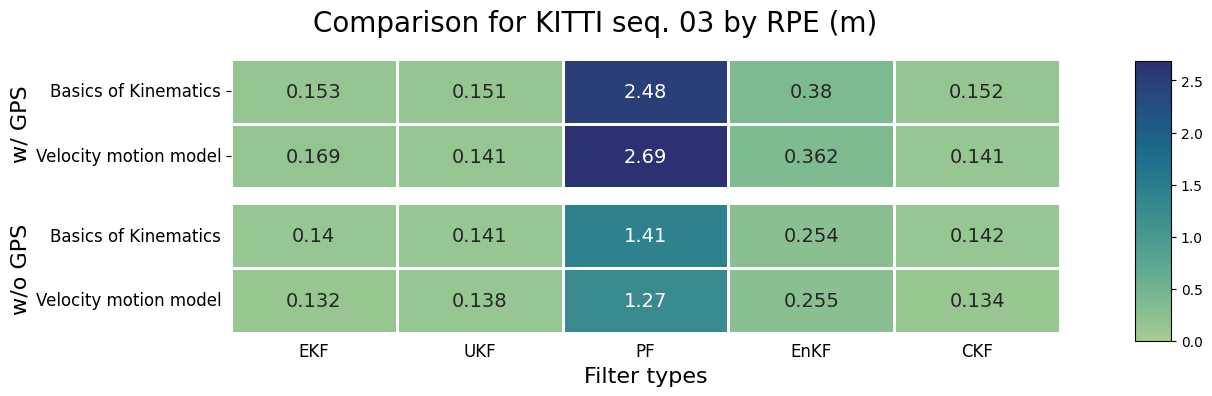

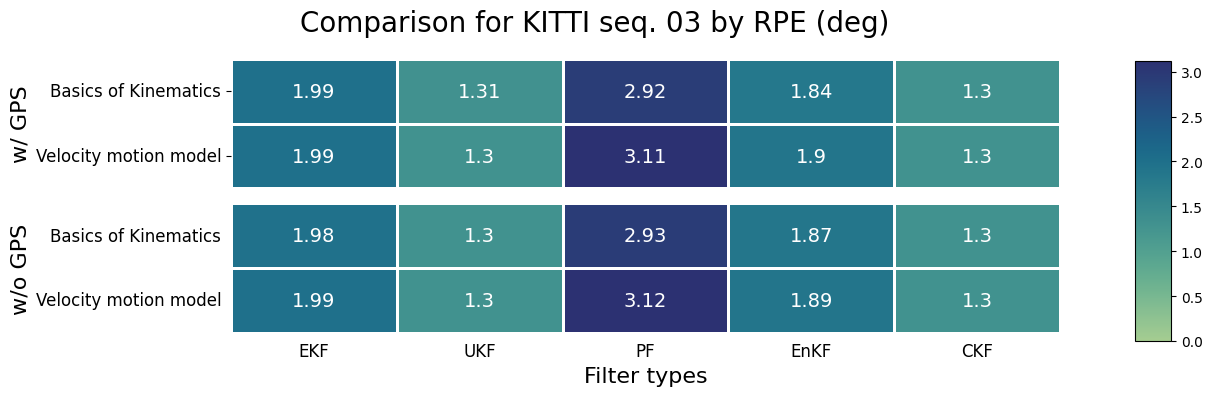

In [59]:
visualize_error_by_sequence(seq_3, [2, 3, 4], "03")

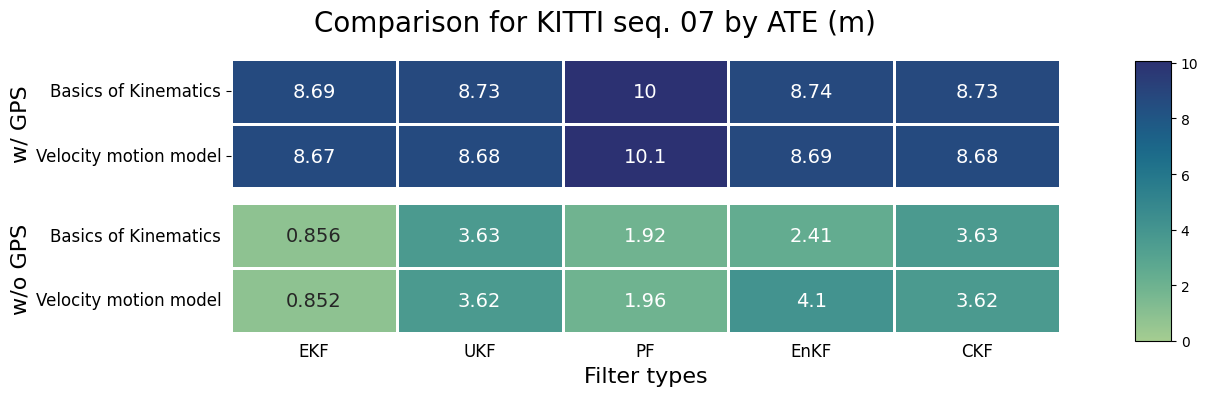

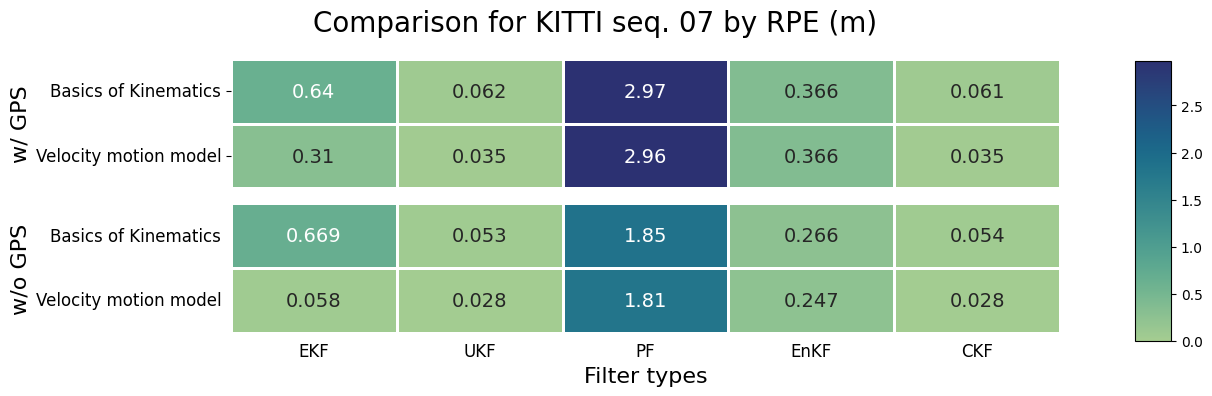

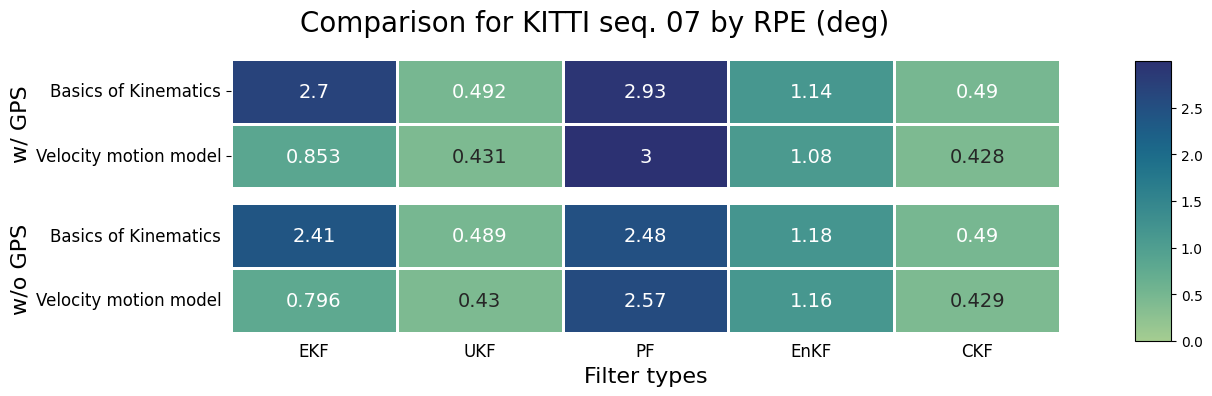

In [60]:
visualize_error_by_sequence(seq_7, [2, 3, 4], "07")

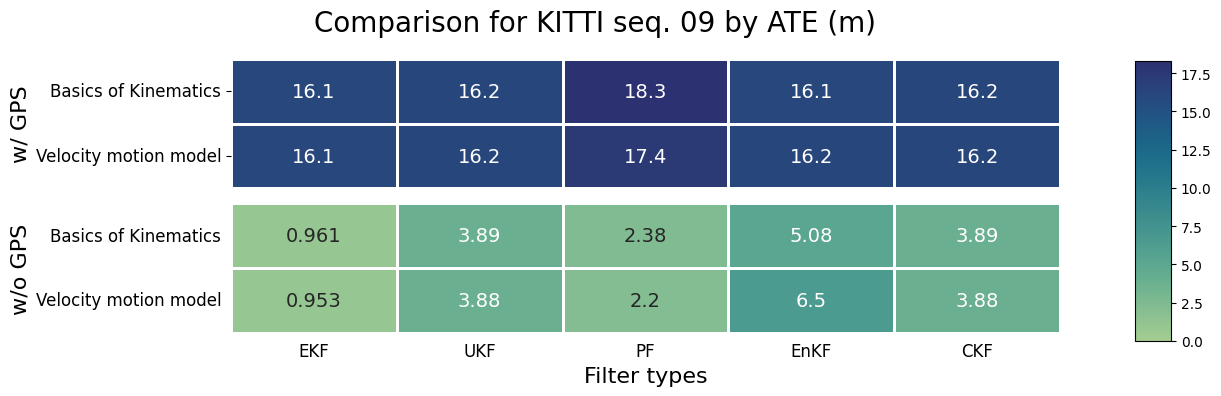

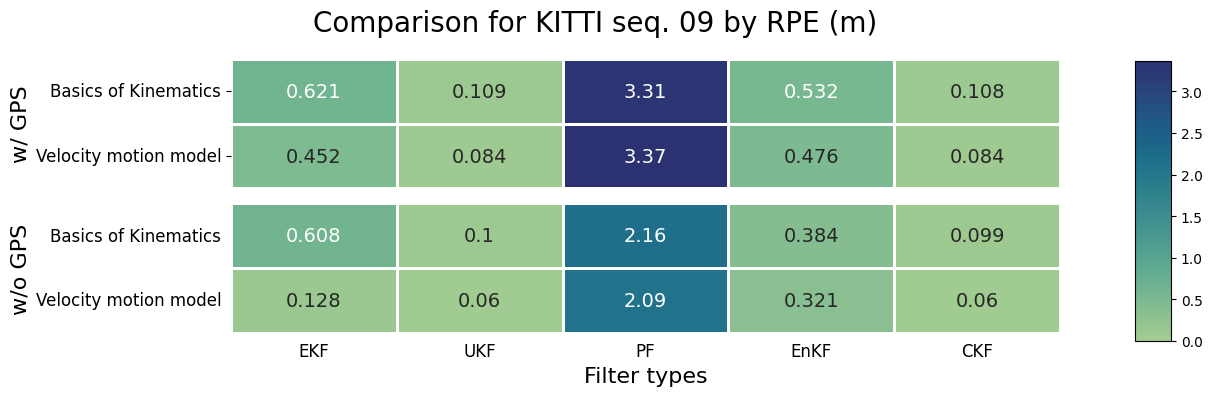

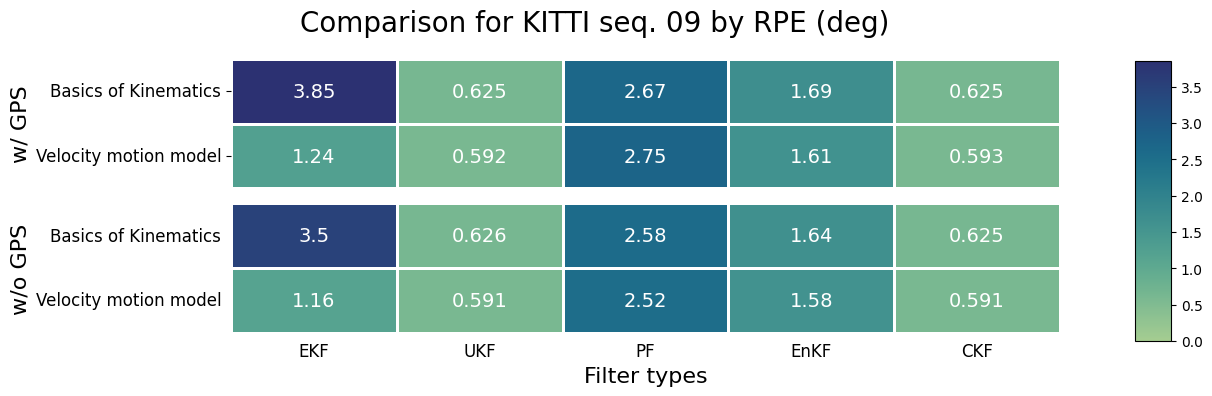

In [61]:
visualize_error_by_sequence(seq_9, [2, 3, 4], "09")

# Inference time analysis

In [19]:
result_root_inference_time_dir = "/app/outputs/KITTI/dataframes/experimental_settings/inference_time/"
sequences = ["Seq. 03", "Seq. 07", "Seq. 09"]
sequences.append("Average (s)")

def get_inference_df(setup_name):
    inference_time_df_path = os.path.join(result_root_inference_time_dir, setup_name + "_03_07_09.csv")
    df = pd.read_csv(inference_time_df_path, index_col=[0])
    df.rename(index={4: "Seq. 04", 7: "Seq. 07", 9: "Seq. 09", 3: "Seq. 03"}, inplace=True)
    return pd.DataFrame(
            np.vstack([df.values, np.mean(df.values, axis=0)]),
            index=df.index.append(pd.Index(["Average"])),
            columns=df.columns
        )

In [20]:
kinematics_w_gps = get_inference_df(setup_names[0])
kinematics_wo_gps = get_inference_df(setup_names[1])
velocity_wo_gps = get_inference_df(setup_names[2])
velocity_w_gps = get_inference_df(setup_names[3])

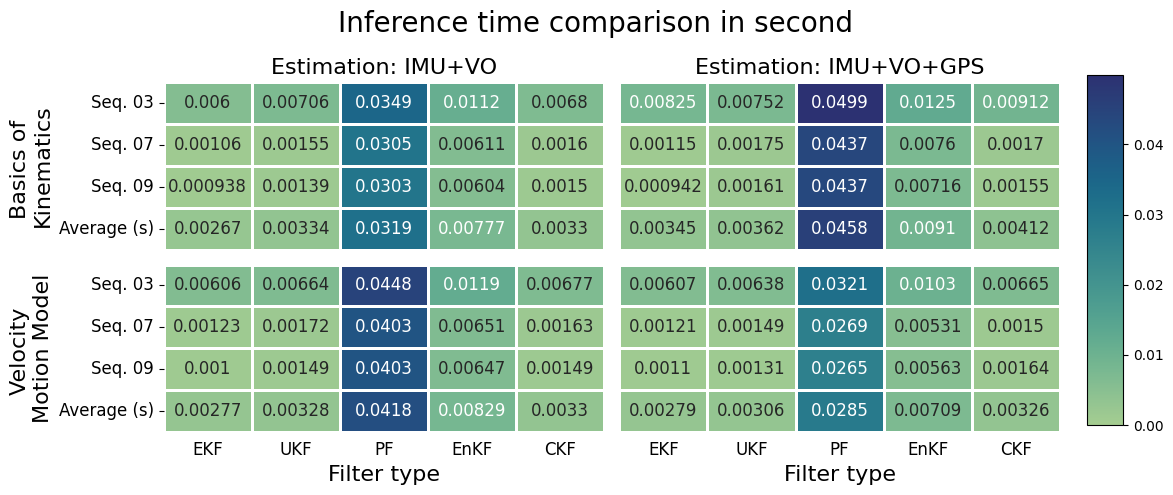

In [33]:

vmin = 0.
vmax = max(np.max(kinematics_w_gps), np.max(kinematics_wo_gps), np.max(velocity_wo_gps), np.max(velocity_w_gps))
# Create a figure with specified layout
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [1, 1]})

# Add an axis for the shared colorbar
cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
display(HTML(f"<h2 style='text-align: left; margin-left: 460px;'>Inference time comparison</h2>"))

fontsize = 12
# Plot the heatmaps
sns.heatmap(
    kinematics_wo_gps, 
    ax=ax1[0], 
    vmin=vmin, 
    vmax=vmax,
    cmap="crest",
    annot=True,
    linewidths=1,
    fmt='.3g',
    cbar=False,
    xticklabels=False,
    yticklabels=sequences,
    annot_kws={'size': fontsize}
)
sns.heatmap(
    kinematics_w_gps, 
    ax=ax1[1], 
    vmin=vmin, 
    vmax=vmax,
    cmap="crest",
    annot=True,
    linewidths=1,
    fmt='.3g',
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot_kws={'size': fontsize}
)
sns.heatmap(
    velocity_wo_gps, 
    ax=ax2[0],
    vmin=vmin, 
    vmax=vmax,
    cmap="crest",
    annot=True,
    linewidths=1,
    fmt='.3g',
    cbar=False,
    xticklabels=filter_names,
    yticklabels=sequences,
    annot_kws={'size': fontsize}
)
sns.heatmap(
    velocity_w_gps, 
    ax=ax2[1],
    vmin=vmin, 
    vmax=vmax,
    cmap="crest",
    annot=True,
    linewidths=1,
    fmt='.3g',
    yticklabels=False,
    cbar=False,
    xticklabels=filter_names,
    annot_kws={'size': fontsize}
)

# Add a colorbar to the dedicated colorbar axis
cmap = cm.get_cmap("crest")

# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(vmin, vmax)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

fig.suptitle("Inference time comparison in second", size=20)
# Add titles or labels if needed
ax1[0].set_title("Estimation: IMU+VO", fontsize=16)
ax1[1].set_title("Estimation: IMU+VO+GPS", fontsize=16)

ax1[0].set_xlabel(None)
ax1[0].set_ylabel("Basics of \nKinematics", fontsize=16)
# ax1[0].set(xlabel=None, ylabel="Basics of Kinematics")
ax2[0].set_xlabel("Filter type", fontsize=16)
ax2[0].set_ylabel("Velocity \nMotion Model", fontsize=16)
# ax2[0].set(xlabel="Filter type", ylabel="Velocity Motion Model")

ax2[1].set_xlabel("Filter type", fontsize=16)
ax2[1].set_ylabel(None)

ax1[0].tick_params(left=True, bottom=False, labelsize=12) ## other options are right and top
ax1[1].tick_params(left=False, bottom=False, labelsize=12) ## other options are right and top
ax2[0].tick_params(left=True, bottom=False, labelsize=12) ## other options are right and top
ax2[1].tick_params(left=False, bottom=False, labelsize=12) ## other options are right and top

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()
